# Convolutional Neural Networks
## Project: Dog-breed Classification

Builded a pipeline that can be used within a web or mobile app to process real-world, user-supplied images. Given an image of a dog,  algorithm will identify an estimate of the canine’s breed. If supplied an image of a human, the code will identify the resembling dog breed.


In [0]:

import zipfile
import os
from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
with zipfile.ZipFile('lfw.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [0]:
with zipfile.ZipFile('haarcascades.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [0]:
with zipfile.ZipFile('dog_images_small.zip', 'r') as zipref:
  zipref.extractall('/content')


## Test for CUDA

In [0]:
import torch

# Check if CUDA is Available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print('CUDA is Available! Training on GPU')
else:
  print('CUDA is not Available! Training on CPU')

CUDA is Available! Training on GPU


## Step 0:Import Datasets

In [0]:
import numpy as np
from glob import glob

#load filenames for human and dog images
human_files = np.array(glob("/content/lfw/*/*"))
dog_files = np.array(glob("/content/dog_images_small/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 6953 total human images.
There are 2152 total dog images.


## Step 1:Detect Humans
In this section, we use OpenCV's implementation of Haar feature-based cascade classifiers to detect human faces in images.


<p>Before using any of the face detectors, it is standard procedure to convert the images to grayscale. The detectMultiScale function executes the classifier stored in face_cascade and takes the grayscale image as a parameter.</p>

<p>In the below code, faces is a numpy array of detected faces, where each row corresponds to a detected face. Each detected face is a 1D array with four entries that specifies the bounding box of the detected face. The first two entries in the array (extracted in the above code as x and y) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two entries in the array (extracted here as w and h) specify the width and height of the box.</p>

Number of faces detected: 1


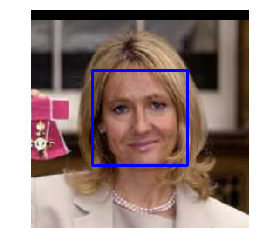

In [0]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/content/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
  # add bounding box to color image
  cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.axis('off')
plt.show()

## Human Face detector
<p>We can use this procedure to write a function that returns True if a human face is detected in an image and False otherwise. This function, aptly named face_detector, takes a string-valued file path to an image as input and appears in the code block below.</p>

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
  img = cv2.imread(img_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray)
  return len(faces) > 0

## Assess the Human Face Detector

In [0]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_face_detections = np.sum([face_detector(img) for img in tqdm(human_files_short)])
dog_face_detections = np.sum([face_detector(img) for img in tqdm(dog_files_short)])

print("\nPercentage of human faces detected in humans dataset: {}%".format(human_face_detections))
print("Percentage of human faces detected in dogs dataset: {}%".format(dog_face_detections))


100%|██████████| 100/100 [00:32<00:00,  2.12it/s]


Percentage of human faces detected in humans dataset: 99%
Percentage of human faces detected in dogs dataset: 16%


## Step 2: Detect Humans

### Obtain pretrained VGG16 model

In [0]:
from torchvision import datasets,models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if train_on_gpu:
    VGG16 = VGG16.cuda()

### Making predictions with pre-trained model

In [0]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

def VGG16_predict(image_path):
  # Load the image from the provided path
  image = Image.open(image_path)
  # Convert data to normalized torch.FloatTensor
  transform = transforms.Compose([transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
  image_tensor = transform(image).float()
  # Pytorch pretrained model expects tensor dimensions to be (batch_size, num_color_channels, height, width)
  # current dimensions are (num_color_channels, height, width), Let's fix this by inserting new axix
  image_tensor = image_tensor.unsqueeze_(0) # insert the new axis at index 0
  # Pytorch models expect inputs to be variables.
  image = Variable(image_tensor) # input to the network needs to be an autograd variable
  if train_on_gpu:
    image = Variable(image_tensor.cuda())
    
  VGG16.eval()
  output = VGG16(image) # returns tensor of shape (batch, num_class_labels)
  output = output.cpu()
  index = output.data.numpy().argmax()

  return index

### Dog Detector

In [0]:
def dog_detector(img_path):
  '''
  Use pre-trained VGG-16 model to check if the image 
  contains a dog or not
  Args:
    img_path: path to an image
  Returns:
    returns "True" if a dog is detected in the image stored at img_path
  '''
  predict_idx = VGG16_predict(img_path)
  if(predict_idx > 150 and predict_idx < 269):
    return True
  else: 
    return False

### Assess the Dog Detector

In [0]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_face_detections = np.sum([dog_detector(img) for img in tqdm(human_files_short)])
dog_face_detections = np.sum([dog_detector(img) for img in tqdm(dog_files_short)])

print("\nPercentage of dogs detected in humans dataset: {}%".format(human_face_detections))
print("Percentage of dogs detected in dogs dataset: {}%".format(dog_face_detections))

100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Percentage of dogs detected in humans dataset: 0%
Percentage of dogs detected in dogs dataset: 96%


## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)
<p>Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. In this step, we will create a CNN that classifies dog breeds</p>

## Specify Data Loaders for Dog Dataset

In [0]:
data_dir = '/content/dog_images_small/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

In [0]:
from torchvision import datasets, transforms

# number of subprocess use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to normalized torch.FloatTensor
data_transforms  = {
    'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'valid' : transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'test' : transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}



In [0]:
image_datasets = {
    'train' : datasets.ImageFolder(root=train_dir,transform=data_transforms['train']),
    'valid' : datasets.ImageFolder(root=valid_dir,transform=data_transforms['valid']),
    'test' : datasets.ImageFolder(root=test_dir,transform=data_transforms['test'])
}

In [0]:
# creating data loaders for training, validation, test data

data_loaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'],batch_size = batch_size,shuffle=True, num_workers = num_workers),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'],batch_size = batch_size, shuffle = True, num_workers = num_workers),
    'test' : torch.utils.data.DataLoader(image_datasets['test'],batch_size = batch_size, num_workers = num_workers)    
}

In [0]:
# print size of training/validation/test set
print("Size of training set is: %d" %(len(image_datasets['train'])))
print("Size of validation set is: %d" %(len(image_datasets['valid'])))
print("Size of testing set is: %d " %(len(image_datasets['test'])))

Size of training set is: 1720
Size of validation set is: 211
Size of testing set is: 221 


In [0]:
# getting the number of classes
num_classes = len(image_datasets['train'].classes)
num_classes

30

## Visualize a batch of training data

In [0]:
# define helper function for unnormalize ad display
def imshow(img):
  img = img.transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)

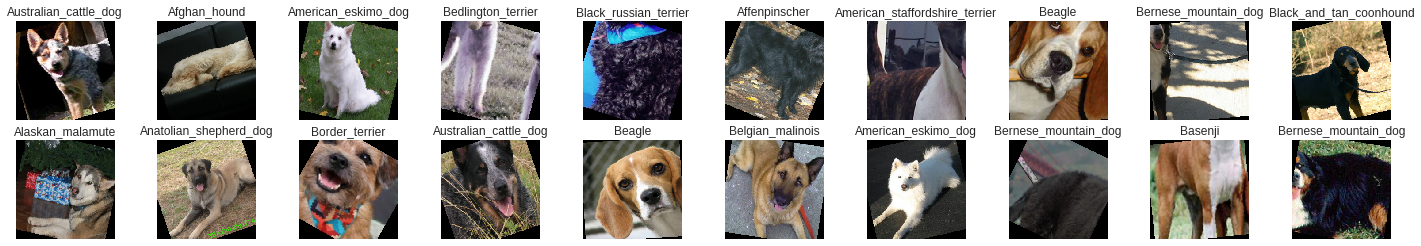

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

class_names = image_datasets['train'].classes
# obtain one batch of training data
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize = (25, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks = [], yticks = [])
  imshow(images[idx])
  ax.set_title(class_names[labels[idx]].split(".")[1])  

## Define the Model Architecture

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # convlutional layer (sees 224x224x3 image tensor)
    self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
    # convlutional layer (sees 112x112x16 image tensor)
    self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
    # convlutional layer(sees 56x56x32 image  tensor)
    self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
    # convlutional layer(sees 28x28x64 image  tensor)
    self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
    # convlutional layer(sees 14x14x128 image  tensor)
    self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
    # max pooling layer
    self.pool = nn.MaxPool2d(2, 2)
    # linear layer (256x7x7 --> 128)
    self.fc1 = nn.Linear(256 * 7 * 7, 32)
    # linear layer (32 --> 133)
    self.fc2 = nn.Linear(32, num_classes)
    # dropout layer
    self.dropout = nn.Dropout(p = 0.25)
    
    # adding optional batch norm layer
    self.batch_norm1 = nn.BatchNorm2d(16)
    self.batch_norm2 = nn.BatchNorm2d(32)
    self.batch_norm3 = nn.BatchNorm2d(64)
    self.batch_norm4 = nn.BatchNorm2d(128)
    self.batch_norm5 = nn.BatchNorm2d(256)
        
  def forward(self, x):
    # add sequence of convlutional and maxpool layers + optional batchnorm layer
    x = self.pool(F.relu(self.conv1(x)))
    x = self.batch_norm1(x)
    x = self.pool(F.relu(self.conv2(x)))
    x = self.batch_norm2(x)
    x = self.pool(F.relu(self.conv3(x)))
    x = self.batch_norm3(x)
    x = self.pool(F.relu(self.conv4(x)))
    x = self.batch_norm4(x)
    x = self.pool(F.relu(self.conv5(x)))
    x = self.batch_norm5(x)
    # flatten image input
    x = x.view(-1, 256 * 7 * 7)
    # add dropout layeer
    x = self.dropout(x)
    # add first hidden layer with relu activation function
    x = F.relu(self.fc1(x))
    # add dropout layer
    x = self.dropout(x)
    # add final layer
    x = self.fc2(x)
    return x


# instantiate the CNN
model_scratch = Net()

# move Model to GPU if CUDA is available
if train_on_gpu:
  print('model moved to GPU')
  model_scratch.cuda()

model moved to GPU


In [0]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=30, bias=True)
  (dropout): Dropout(p=0.25)
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

## specify loss function and optimizer

In [0]:
import torch.optim as optim

#specify loss function
criterion_scratch = nn.CrossEntropyLoss()

### specify optimizer
optimizer_scratch = torch.optim.RMSprop(model_scratch.parameters(), lr = 1e-4)

## Train the Network

In [0]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, save_path):
  """returns trained model"""
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
  for epoch in range(1, n_epochs+1):
    # initialize variables to minitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prepare the model for training
    for batch_idx, (data, target) in enumerate(loaders['train']):
      # move tensors to GPU if CUDA is Available
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
      # clear the gradient of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute the predicted outputs by passing inputs to the model
      output = model(data)
      # calcualte the loss
      loss = criterion(output, target)
      # backward pass: compute the gradient of the loss with repect to model parameters
      loss.backward()
      # perform optimtizer step(parameter update)
      optimizer.step()
      # update average training loss
      train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
      
    ######################
    # validate the model #
    ######################
    model.eval() # prepare model for training
    
    for batch_idx, (data, target) in enumerate(loaders['valid']):
      # move tensors to GPU if CUDA is Available
      if train_on_gpu:
        
        data, target = data.cuda(), target.cuda()
      # forward pass: compute the predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the loss
      loss = criterion(output, target)
      # update average validation loss
      valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch,
        train_loss,
        valid_loss, 
         ))
    # save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      print('validation loss decrased from ({:.4f} --> {:.4f})  Saving the model....'.format(
            valid_loss_min,
            valid_loss))
      torch.save(model.state_dict(), save_path)
      valid_loss_min = valid_loss
  # reurn the trained model
  return model




In [0]:
loaders_scratch = data_loaders
n_epochs = 30
# train the model
model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, train_on_gpu, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 3.327504 	Validation Loss: 3.394944
validation loss decrased from (inf --> 3.3949)  Saving the model....
Epoch: 2 	Training Loss: 3.197930 	Validation Loss: 3.154198
validation loss decrased from (3.3949 --> 3.1542)  Saving the model....
Epoch: 3 	Training Loss: 3.153801 	Validation Loss: 3.169857
Epoch: 4 	Training Loss: 3.098744 	Validation Loss: 3.057607
validation loss decrased from (3.1542 --> 3.0576)  Saving the model....
Epoch: 5 	Training Loss: 3.040791 	Validation Loss: 3.040776
validation loss decrased from (3.0576 --> 3.0408)  Saving the model....
Epoch: 6 	Training Loss: 2.978835 	Validation Loss: 3.087004
Epoch: 7 	Training Loss: 2.963806 	Validation Loss: 3.061897
Epoch: 8 	Training Loss: 2.930247 	Validation Loss: 2.965899
validation loss decrased from (3.0408 --> 2.9659)  Saving the model....
Epoch: 9 	Training Loss: 2.921670 	Validation Loss: 2.985386
Epoch: 10 	Training Loss: 2.885850 	Validation Loss: 3.005747
Epoch: 11 	Training Loss: 2.8378

## Test the model

In [0]:
def test(loaders, model, criterion, train_on_gpu):
  # monitor test loss and accuracy
  test_loss = 0.
  correct = 0.
  total = 0.

  model.eval()
  for batch_idx, (data, target) in enumerate(loaders['test']):
    # move to GPU
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update average test loss 
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)
            
  print('Test Loss: {:.6f}\n'.format(test_loss))

  print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, train_on_gpu)

Test Loss: 2.679481


Test Accuracy: 20% (45/221)


## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)
<p>we will now use transfer learning to create a CNN that can identify dog breed from image</p>

## Model Architecture

In [0]:
# load pre-trained model from pytorch
model_transfer = models.vgg16(pretrained = True)

# print out the model struture
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
print(model_transfer.classifier[6].in_features)
print(model_transfer.classifier[6].out_features)

4096
1000


** freezing simply means parametrs in thr pretrained model will not change during training **

In [0]:
# freeze the training for all 'features layers
for param in model_transfer.features.parameters():
  param.requires_grad = False

## Final Classifier Layer

In [0]:
n_inputs = model_transfer.classifier[6].in_features

# add last layer (n_inputs --> 10)
# new layers will automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, num_classes)
model_transfer.classifier[6] = last_layer



# move model to GPU if CUDA is Available
if train_on_gpu:
  model_transfer.cuda()

## Specify Loss Function and optimizer

In [0]:
# specify loss function
criterion_transfer = nn.CrossEntropyLoss()
# specify optimizer
optimizer_transfer = optim.RMSprop(model_transfer.classifier.parameters(), lr = 1e-4)

## Train and Validate the Model

In [0]:

loaders_transfer = data_loaders
n_epochs = 20
# train the model
model_transfer =  train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer,
                        criterion_transfer, train_on_gpu, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 1.756907 	Validation Loss: 0.406972
validation loss decrased from (inf --> 0.4070)  Saving the model....
Epoch: 2 	Training Loss: 0.975810 	Validation Loss: 0.453397
Epoch: 3 	Training Loss: 0.861220 	Validation Loss: 0.340815
validation loss decrased from (0.4070 --> 0.3408)  Saving the model....
Epoch: 4 	Training Loss: 0.805138 	Validation Loss: 0.350749
Epoch: 5 	Training Loss: 0.738674 	Validation Loss: 0.317868
validation loss decrased from (0.3408 --> 0.3179)  Saving the model....
Epoch: 6 	Training Loss: 0.666140 	Validation Loss: 0.385972
Epoch: 7 	Training Loss: 0.661302 	Validation Loss: 0.298215
validation loss decrased from (0.3179 --> 0.2982)  Saving the model....
Epoch: 8 	Training Loss: 0.569735 	Validation Loss: 0.300635
Epoch: 9 	Training Loss: 0.581935 	Validation Loss: 0.359776
Epoch: 10 	Training Loss: 0.576535 	Validation Loss: 0.435552
Epoch: 11 	Training Loss: 0.576200 	Validation Loss: 0.365859
Epoch: 12 	Training Loss: 0.542860 	Valida

## Test the Model

In [0]:
# test the model performance
test(loaders_transfer, model_transfer, criterion_transfer, train_on_gpu)

Test Loss: 0.252764


Test Accuracy: 91% (203/221)


### Predict a Dog breed with the Model

In [0]:
#  list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

In [0]:
from PIL import Image
import torchvision.transforms as transforms

def load_input_image(img_path):    
  image = Image.open(img_path).convert('RGB')
  prediction_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

  # discard the transparent, alpha channel (that's the :3) and add the batch dimension
  image = prediction_transform(image)[:3,:,:].unsqueeze(0)
  return image

In [0]:
def predict_breed_transfer(model, class_names, img_path):
  # load the image and return the predicted breed
  img = load_input_image(img_path)
  model = model.cpu()
  model.eval() # prepare the model for evaluation
  idx = torch.argmax(model(img))
  return class_names[idx]

In [0]:
img_path = dog_files[75]
predition = predict_breed_transfer(model_transfer, class_names, img_path)
print("image_file_name: {0}, \t predition breed: {1}".format(img_path, predition))

image_file_name: /content/dog_images_small/valid/023.Bernese_mountain_dog/Bernese_mountain_dog_01645.jpg, 	 predition breed: Bernese mountain dog


## Step 5: Writing algorithm
- if a dog is detected in the image, return the predicted breed.
- if a human is detected in the image, return the resembling dog breed.
- if neither is detected in the image, provide output that indicates an error.

In [0]:
def run_app(img_path):
  ## handle cases for a human face, dog, and neither
  plt.axis('off')
  plt.imshow(plt.imread(img_path))
  plt.show()
  is_human = face_detector(img_path)
  is_dog = dog_detector(img_path)
  if is_human:
    prediction = predict_breed_transfer(model_transfer, class_names, img_path)
    print("Human Detected  \n hello, human! you  look like a ...... {} ".format(prediction))
    return
  elif is_dog:
    prediction = predict_breed_transfer(model_transfer, class_names, img_path)
    print("Dog Detected \n hello, dog! your  predicted breed is......{} ".format(prediction))
    return
  else:
    print("Neither a human nor a dog")
    return

## Testing Algorithm

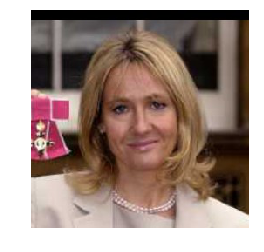

Human Detected  
 hello, human! you  look like a ...... Bearded collie 


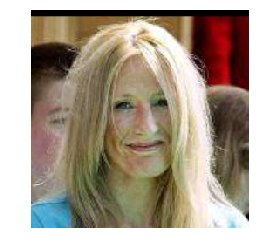

Human Detected  
 hello, human! you  look like a ...... Afghan hound 


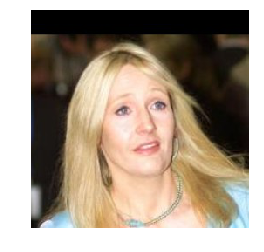

Human Detected  
 hello, human! you  look like a ...... Bearded collie 


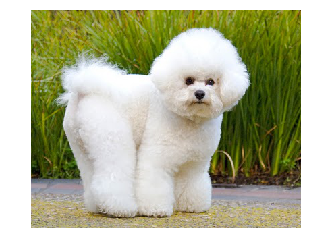

Human Detected  
 hello, human! you  look like a ...... Bichon frise 


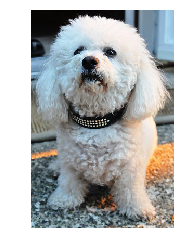

Dog Detected 
 hello, dog! your  predicted breed is......Bichon frise 


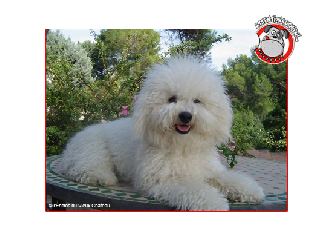

Dog Detected 
 hello, dog! your  predicted breed is......Bichon frise 


In [0]:
for file in np.hstack((human_files[:3], dog_files[:3])):
  run_app(file)